# TD 10 Bayesian Inference on Gravitational Waves.  Part 1: Artificial Data

Toy model:  the signal is a linear function d of one variable x  with 2 parameters theta the intercept, called distance and the slope called mass , 
d is sampled on M bins with a  gaussian random noise, with variance sigma2 depending on
the bin. x is choosen in the interval 0,1. 
values. np.random.seed(1) is used to have reproducible results.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import inf
from numpy import power
from numpy import isfinite


import random
np.random.seed(1)
M = 200
#x = np.random.uniform(0,2,size=M)
#x=np.arange(M)/M/2
x=np.arange(M)/M
#alpha_true = 0.5
distance_true = 800
m_true = 30
alpha= np.random.uniform(-2,6, size=M)
sigma2_true=np.exp(alpha)
#random.uniform(0,1, size=M)
d_true = distance_true + m_true*x 
d = d_true + np.random.normal(0, sigma2_true, size=M)

Plot of the fixed variance as a function of the bin. 

Text(0.5, 0, 'bin')

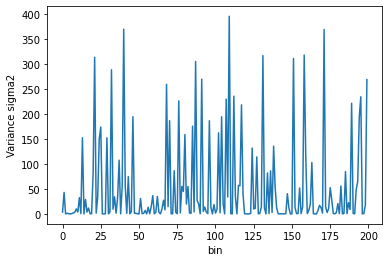

In [2]:
plt.plot(sigma2_true)
plt.ylabel('Variance sigma2')
plt.xlabel('bin')

Plot of the observed signal as a function of the known signal

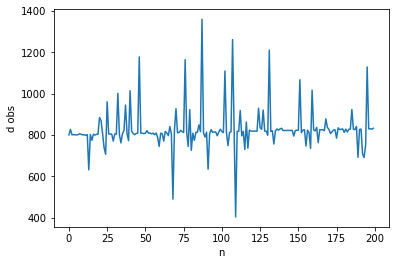

In [3]:
plt.xlabel('n')
plt.ylabel('d obs')
plt.plot(d)

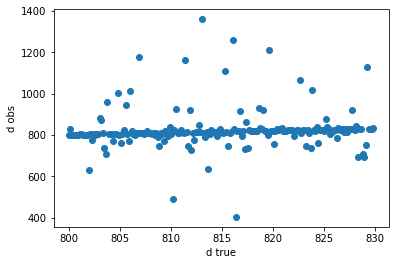

In [4]:
plt.xlabel('d true')
plt.ylabel('d obs')
plt.scatter(d_true,d)

Functions

In [5]:
def lnprior(theta,type_prior):
    # The parameters are stored as a vector of values, so unpack them
    #I define the prior in this routine here just positive parameters 
    #put 1 as lower bound
    if(type_prior=='pos'):
        int0=0,0
        int1=inf,inf
        #uniform prior in an interval defined here
    elif(type_prior=='inint'):
        int0=20, 100
        int1=300, 3000
        
    
    m, distance = theta

    m0, distance0 = int0
    m1, distance1 = int1
    
    
    if (distance0 <= distance <= distance1)  & (m0 <= m <=m1): 
        return 0
    else: 
         return -np.inf

In [6]:
#Gaussian loglikelihood 
def lnlike(theta,x,d,sigma2):
    M=np.size(d)
    m,distance= theta
    #predicted d at fixed parameters
    d_theta = distance + m*x 
    # the likelihood is sum of the lot of normal distributions
    #the term -0.5*M*log(2*pi) is a constant not useful
    lp = -0.5*sum(np.power((d - d_theta),2)/sigma2)  
    return lp



In [7]:
def lnprob(theta,x,d,sigma2,type_prior):
    lp = lnprior(theta,type_prior)
    if not isfinite(lp):
        return -inf
    return lp + lnlike(theta, x, d,sigma2)
   

In [19]:
#simplest case of 2 parameters to update distances amplitude theta_amp of moves =10, mass amplitude of changes=1
def mcmove(theta_old, x, d, sigma2, type_prior):
#chose the parameter to update if multiple parameters
    i = np.random.randint(2) #only on3 
    theta_amp=[1,10]
#move the parameter of dp, gaussian, average 0, variance a step in the MCMC sample fixed to 1 for mass, 10 for distance, but I have to change 
    dtheta=np.random.normal(0,theta_amp[i])
    theta_new=np.copy(theta_old)
    theta_new[i]=theta_old[i]+dtheta
    lnprob_old=lnprob(theta_old, x, d,sigma2,type_prior)
    lnprob_new=lnprob(theta_new, x, d,sigma2,type_prior)
    
    if not np.isfinite(lnprob_new):
        return theta_old, lnprob_old 
    else:
        dlnprob=lnprob_new-lnprob_old
        if(dlnprob>0):
            theta_up=theta_new
            lnprob_up=lnprob_new
        else:
            a=random.uniform(0,1)
            if (np.exp(dlnprob)>a):
                theta_up=theta_new
                lnprob_up=lnprob_new  
            else:
                theta_up=theta_old
                lnprob_up=lnprob_old  
        return theta_up,lnprob_up 

Start here

Choose prior

In [41]:
type_prior='inint'
#type_prior='pos'

# Compute the logprobability of the true parameters with the choosen prior note that the absolute
#value depend is not important (we have negleted a term) 
sigma2=sigma2_true
theta=m_true,distance_true

ll_true=lnlike(theta, x, d,sigma2_true)
lnprior_true=lnprior(theta,type_prior)

lnprob_true=lnprob(theta, x, d,sigma2_true,type_prior)
print(ll_true,type_prior)


-4977.833388248963 inint


In [42]:
#debug check a mc move
#starting condition in the smallest possible values of parameters 

if(type_prior=='pos'):
    int0=0,0
elif(type_prior=='inint'):
    int0=20,100
theta0=int0
lnp0=lnprob(theta0,x,d,sigma2_true,type_prior)
[p_up,lnprob_up]= mcmove(theta0,x,d,sigma2_true,type_prior)
print(p_up)
print(lnp0,lnprob_up)

(20, 100)
-57998967.35845923 -57998967.35845923


In [43]:
# MonteCarlo to sample the log-posterior, after equilibration we will plot the distribution 
#of the parameters on the posterios

mcstep=1000

theta_t=np.zeros((mcstep,2))

if(type_prior=='pos'):
    int0=0,0
elif(type_prior=='inint'):
    int0=20,300
    
theta_t[0,:]=int0
lnp_t=np.zeros(mcstep)
lnp_t[0]=lnprob(theta_t[0],x,d,sigma2_true,type_prior)

for k in range(1,mcstep):
    theta0=theta_t[k-1,:]
    [theta_new,lnp_t[k]]= mcmove(theta0,x,d,sigma2_true,type_prior)
    theta_t[k,:]=theta_new

Plot the log probability as a function of the MC step

-4980.70306193649
[ 30.38868709 799.83935464]


FileNotFoundError: [Errno 2] No such file or directory: './Figures/post_data_nonneg_pr.pdf'

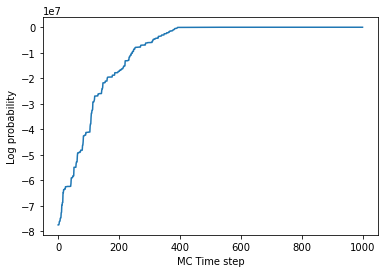

In [13]:
print(lnp_t[mcstep-1])
print(theta_t[mcstep-1,:])
plt.plot(lnp_t)
plt.ylabel("Log probability")
plt.xlabel("MC Time step")
if(type_prior=='pos'):
    nameplot='./Figures/post_data_nonneg_pr.pdf'
else:
     nameplot='./Figures/post_data_int_pr'
plt.savefig(nameplot)
plt.show()

Define the  MC step at which the distribution become stationary

In [ ]:
theta_eq=theta_t[500:mcstep-1,:]

In [ ]:
#Print the equilibrium  average values  of parameters over the posterior distribution  and the standard deviations  
print(np.mean(theta_eq[:,0]),'+-', np.std(theta_eq[:,0]),np.mean(theta_eq[:,1]),'+-',np.std(theta_eq[:,1]))

33.27692309281888 +- 4.647800211139284 798.1031935837601 +- 2.595807613391793


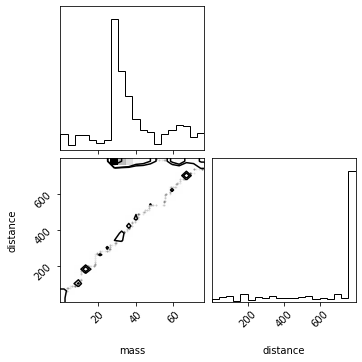

In [ ]:
#Corner plot to show the evolution of parameters in the MC sampling and their correlarions
import corner
corner.corner(theta_t,labels=['mass',
                                'distance']);
if(type_prior=='pos'):
    nameplot='./Figures/corner_nonneg_pr.pdf'
else:
     nameplot='./Figures/corner_int_pr'
plt.savefig(nameplot)